# Part II - Data Exploration (Prosper Loan Dataset)
## by (Duc Truong)

## Investigation Overview


> This investigation will dig into 2 key insights:
- Which factors can be used to predict default chance (when the borrowers cannot pay the loans with interest)?
- Which factors may affect Prosper ratings?


## Dataset Overview

> The Prosper Loan dataset contains 113,937 rows of information of loans with 81 variables on each loan. To serve the purpose of this investigation, I choose to keep the following variables in a new table named main_table: Term, LoanStatus, BorrowerRate, ProsperRating (Alpha), ListingCategory (numeric), EmploymentStatus, DelinquenciesLast7Years, StatedMonthlyIncome, TotalProsperLoans, LoanOriginalAmount, LoanOriginationDate, Recommendations, Investors.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
df = pd.read_csv('prosperLoanData.csv')

In [3]:
# Some data wrangling steps are taken before making visualization
# 1 - Keep some necessary columns and create new table
main_columns =  [
    'Term', 'LoanStatus', 'BorrowerRate', 'ProsperRating (Alpha)', 'ListingCategory (numeric)', 'EmploymentStatus',
    'DelinquenciesLast7Years', 'StatedMonthlyIncome', 'TotalProsperLoans', 'LoanOriginalAmount',
    'LoanOriginationDate', 'Recommendations', 'Investors'
]
main_table = df[main_columns]

# 2 - Prosper Rating is applied after July 2009, so rows with missing value in ProsperRating column are dropped
main_table = main_table.dropna(subset=['ProsperRating (Alpha)']).reset_index()

# 3 - Convert 'LoanOriginationDate' into datetime datatype
main_table['LoanOrginationDate'] = pd.to_datetime(main_table['LoanOriginationDate'])

# 4 - TotalProsperLoans column has missing values (NaN), so replace them with 0
main_table['TotalProsperLoans'] = main_table['TotalProsperLoans'].fillna(0)

# 5 - Keep only 3 values of column LoanStatus
condition = (main_table['LoanStatus'] == 'Completed') | (main_table['LoanStatus'] == 'Defaulted') |\
            (main_table['LoanStatus'] == 'Chargedoff')
main_table = main_table[condition]
# Set 'Chargedoff' to 'Defaulted'
def set_to_defaulted(row):
    if row['LoanStatus'] == 'Chargedoff':
        return 'Defaulted'
    else:
        return row['LoanStatus']
main_table['LoanStatus'] = main_table.apply(set_to_defaulted, axis = 1)

# 6 - Turn categories with value 1,2,3,6 into categorical name, and put all other value into 7
categories = {1: 'Debt Consolidation', 2: 'Home Improvement', 3: 'Business', 6: 'Auto', 7: 'Other'}
def refine_categories(row):
    list_category = row['ListingCategory (numeric)']
    if list_category in categories:
        return categories[list_category]
    else:
        return categories[7]
main_table['ListingCategory (numeric)'] = main_table.apply(refine_categories, axis = 1)

# 7 - Apply Three-Sigma Limit formula for statistical control to set a limit value for StatedMonthlyIncome
income_std = main_table['StatedMonthlyIncome'].std()
income_mean = main_table['StatedMonthlyIncome'].mean()
limit = income_mean + income_std * 3

## Visualization 1: Display defaulted loans based on LoanOriginalAmount and ProsperRating
- The completed loans have wider range of LoanOriginalAmount than defaulted ones. Each column of completed loans shows many outliers that exceed 25000, which is the maximum value for defaulted loans. This means that if borrowers realize they can pay back the loans, then they can decide to borrow a loan over 25000. 
- In almost all rating score (except HR), defaulted loans have higher median of LoanOriginalAmount than the completed loans. This may reveal a fact that many borrowers who try to borrow more money tend to be unable to pay back.

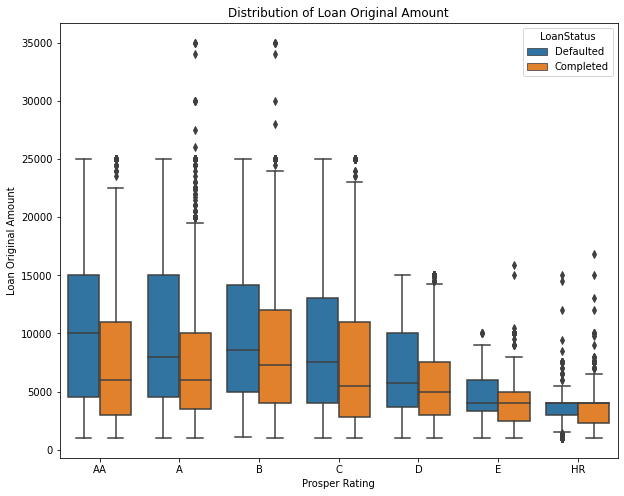

In [25]:
# Visualization 1: Display the distribution of values in LoanOriginalAmount, categorized by LoanStatus (2 colors 
# of columns) and ProsperRating (x-axis)
plt.figure(figsize = [10,8])
sb.boxplot(data = main_table, x = 'ProsperRating (Alpha)', y = 'LoanOriginalAmount', hue = 'LoanStatus',
          order = ['AA', 'A', 'B', 'C', 'D', 'E', 'HR']).set(title = 'Distribution of Loan Original Amount',
                                                            xlabel = 'Prosper Rating',
                                                            ylabel = 'Loan Original Amount');

## Visualization 2: Display defaulted loans based on StatedMonthlyIncome and ProsperRating
- The borrowers who have defaulted loans tend to have lower income than the ones with completed loans
- The borrowers with high ratings tend to have higher income (most noticeably in AA, A, and B group)

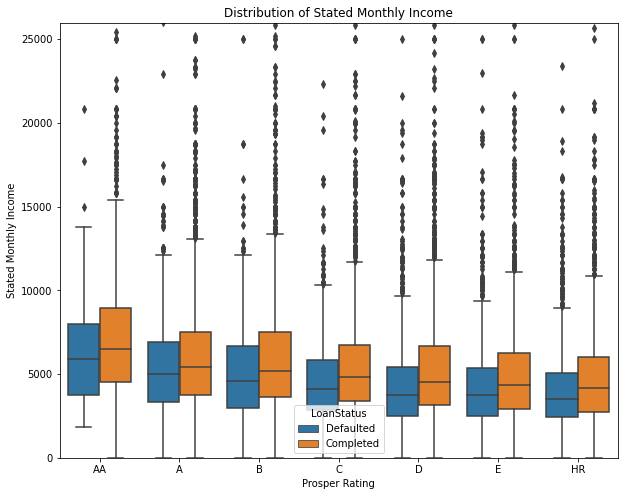

In [26]:
# Visualization 2: Display the distribution of values in StatedMonthlyIncome, categorized by LoanStatus (2 colors 
# of columns) and ProsperRating (x-axis)
plt.figure(figsize = [10,8])
sb.boxplot(data = main_table, x = 'ProsperRating (Alpha)', y = 'StatedMonthlyIncome', hue = 'LoanStatus',
          order = ['AA', 'A', 'B', 'C', 'D', 'E', 'HR']).set(title = 'Distribution of Stated Monthly Income',
                                                            xlabel = 'Prosper Rating',
                                                            ylabel = 'Stated Monthly Income')
plt.ylim(0, limit);

## Visualization 3: Display the number of borrowers in each group of EmploymentStatus, categorized by ProsperRating
- For all rating scores, Employed is always the group with highest number of borrowers. This mean employed people have a big demand of borrowing money.
- The Not employed, Self-employed, Retired and Part-time groups have higher counts in rating HR, D, and E than high ratings. This reveal a fact that those groups may earn little money, so that they cannot pay back loans in time and their ratings are low. 

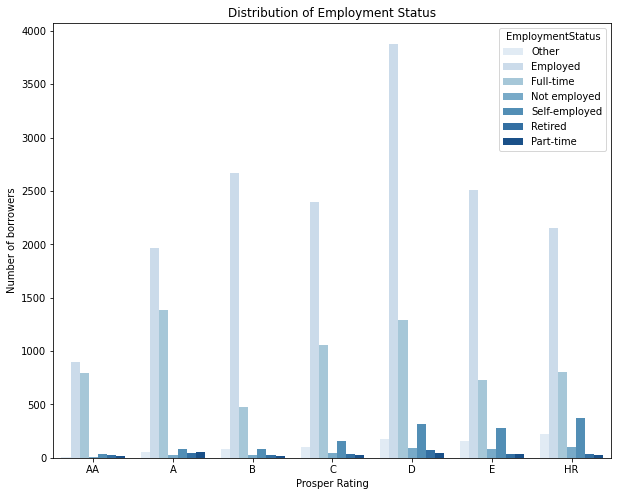

In [27]:
# Visualization 3: Display the distribution of values in EmploymentStatus, categorized by values of ProsperRating
plt.figure(figsize = [10, 8])
sb.countplot(data = main_table, x = 'ProsperRating (Alpha)', hue = 'EmploymentStatus', palette = 'Blues',
            order = ['AA', 'A', 'B', 'C', 'D', 'E', 'HR']).set(title = 'Distribution of Employment Status',
                                                            xlabel = 'Prosper Rating',
                                                            ylabel = 'Number of borrowers');

## Visualization 4: Display the number of borrowers in each group of ListingCategory, categorized by LoanStatus
- Most of the borrowers are in Debt Consolidation group. 

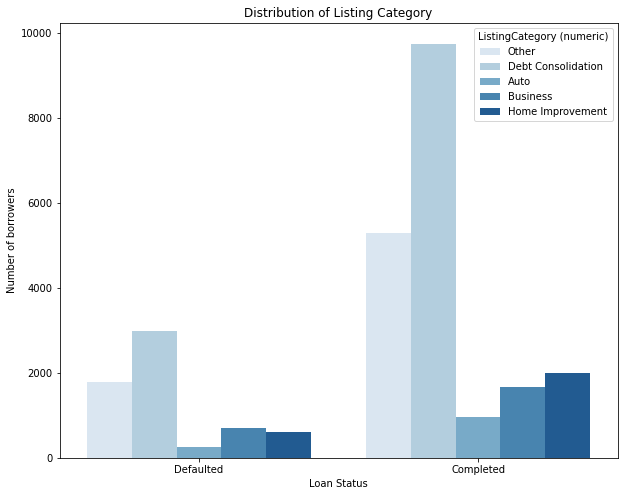

In [29]:
# Visualization 4: Display the distribution of values in ListingCategory column, categorized by 2 values of LoanStatus
plt.figure(figsize = [10, 8])
sb.countplot(data = main_table, x = 'LoanStatus', hue = 'ListingCategory (numeric)', 
             palette = 'Blues').set(title = 'Distribution of Listing Category',
                                    xlabel = 'Loan Status',
                                    ylabel = 'Number of borrowers');

In [ ]:
# Command generates the HTML slideshow. 
!jupyter nbconvert Part_II_slide_deck.ipynb --to slides --post serve --no-input --no-prompt 